# Emcee subfit
16 November 2019

Now that we've shown that `emcee` can work, given that we initialize all the walkers near the correct lens value, let's try to use it to fit subhalos!

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import emcee

# Generate original image

In [2]:
# some standard python imports #
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cms
#%matplotlib inline

from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver
import lenstronomy.Plots.output_plots as lens_plot
from lenstronomy.LightModel.light_model import LightModel
import lenstronomy.Util.param_util as param_util
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Data.pixel_grid import PixelGrid
from lenstronomy.ImSim.image_model import ImageModel
from lenstronomy.Data.psf import PSF
import lenstronomy.Util.image_util as image_util
from lenstronomy.Workflow.fitting_sequence import FittingSequence

from astropy.cosmology import FlatLambdaCDM
import astropy.units as u

import copy

In [3]:
def ADD(z1,z2):
    ## This is a function that computes the angular diameter distance
    ## between two redshifts z1 and z2.
    cosmo = FlatLambdaCDM(H0=70, Om0=0.316) 
    return cosmo.angular_diameter_distance_z1z2(z1,z2)

def sigma_cr(zd,zs):
    ## This function calculates the critical surface mass density at
    ## redshift zd, relative to the source redshift zs.
    const = 1.663e18*u.M_sun / u.Mpc##c^2/(4 pi G)
    return const*(ADD(0,zs)/(ADD(zd,zs)*ADD(0,zd))) ##in units Msun/Mpc^2

def gfunc(c):
    ## This is the g(c) function that is defined
    ## commonly in NFW profiles.
    a = np.log(1.+c) - (c/(1.+c))
    return 1./a

def rs_angle(zd,rs): 
    ##takes in interloper redshift, gives you the scale redius in angular units
    Dd = ADD(0,zd)
    rs_mpc = rs*u.Mpc
    return ((1./4.848e-6)*rs_mpc)/Dd ##gives in arcsec

def alpha_s(m,rs,zd,zs):
    ##takes in subhalo mass, scale radius, interloper redshift, source redshift
    ##returns the angular deflection at scale radius
    m_msun = m*u.M_sun
    rs_mpc = rs*u.Mpc
    con = (1./np.pi)*gfunc(200.)*(1.-np.log(2))
    return m_msun/((rs_mpc**2.)*sigma_cr(zd,zs))

def k_ext(N,m,A,zd,zs,pixsize):
    ## FOR NOW THIS IS SET TO ZERO BECAUSE I CAN'T GET IT TO WORK
    m_msun = m*u.M_sun
    A_mpc2 = (pixsize**4)*(ADD(0.,zd)**2.)*A*((4.848e-6)**2.)  ##arcsec conversion
    return 0.##-(N*m_msun)/(A_mpc2*sigma_cr(zd,zs))


def xi_to_x(xi,z):
    ##takes in physical coordinates (Mpc), turns it into angular coordinates (arcsec)
    x = np.array(((xi*u.Mpc)/ADD(0.,z))/4.848e-6)
    y = x.astype(np.float)
    return y

def x_to_xi(x,z):
    ##takes in angular coordinates (arcsec), turns it into physical coordinates (Mpc)
    return ((x*4.848e-6)*ADD(0,z))/u.Mpc

def xi_to_pix(xi,z,pixsize,pixnum):
    ## takes in physical coordinates (Mpc), identifies the appropriate pixel number
    return (xi_to_x(xi,z))/pixsize + pixnum/2.

**Image-generation parameters**

In [4]:
## REDSHIFTS #######################################################################################
Nit = 100 ##Number of different redshifts
zds = np.linspace(0.01,0.99,Nit)
####################################################################################################



## SOURCE PROPERTIES ###############################################################################
r_sersic_source = 10.0
e1s, e2s = param_util.phi_q2_ellipticity(phi=0.8, q=0.2)
beta_ras, beta_decs = [1.7],[0.3]#this is the source position on the source plane

n_sersic_source = 1.5

## SOURCE-CLUMP PROPERTIES #########################################################################
r_sersic_source_clumps = 1/3.
N_clump = 0
clumprandx = np.random.rand(N_clump)
clumprandy = np.random.rand(N_clump)

source_scatter = 1. ## This is how wide the scatter of the clumps over the smooth source

n_sersic_source_clumps = 1.5

####################################################################################################



## LENS PROPERTIES #################################################################################
theta_lens = 10.
zl = 0.2
r_theta_lens = x_to_xi(theta_lens,zl)
e1, e2 = param_util.phi_q2_ellipticity(phi=-0.9, q=0.8)
gamma = 2.

center_lens_x, center_lens_y = 0.,0.
####################################################################################################



## IMAGE PROPERTIES ################################################################################
pixsize = 0.2
####################################################################################################



## INTERLOPER PROPERTIES ########################################################################### 
N = 1 ##Number of perturbers
M = 1 ##Averaging different realizations

disc_size = 2. ##  interlopers are randomly distributed to a disk that is this
               ##  this times bigger than the einstein radius of the lens
# Perturbers are uniformly distributed within a disk of radius `disc_size * r_theta_lens`
r2s = ((disc_size*r_theta_lens)**2.)*(np.random.rand(N,M))
rss = np.sqrt(r2s)
theta_p = 2.*np.pi*(np.random.rand(N,M))
xs = rss*np.cos(theta_p)
ys = rss*np.sin(theta_p)
xpixs = np.zeros([Nit,N,M]) # will add pixel values in the next cell
ypixs = np.zeros([Nit,N,M]) #
####################################################################################################

## Specific image $-$ choose `j`, `k`
Note that we'll be choosing one specific redshift and one specific statistic for now.

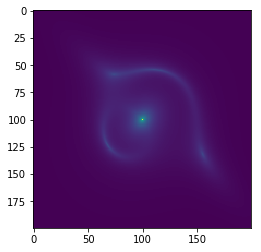

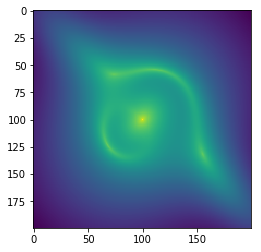

In [5]:
j = 50 # arbitrary choice (loop over redshifts)
k = 0 # also arbitrary choice (loop over statistics)

beta_ra, beta_dec = beta_ras[0], beta_decs[0]

xpixs[j] = xi_to_pix(xs,zds[j],pixsize,200)   ## AT THAT REDSHIFT CALCULATING THE INTERLOPER
ypixs[j] = xi_to_pix(ys,zds[j],pixsize,200)   ## POSITIONS. (THEY ARE RANDOMLY GENERATED IN THE EARLIER BOX)

m =1.0e7 # mass of interlopers
if j == 0:
    m = 0. # so that the first image will be pure (no interloper effect)
zs = 1.
zd = zds[j] # interloper redshift
rs = 0.001  # interloper scale radius r_s
A = 80**2 ## in arcsec ## IGNORE THIS, THIS WAS FOR NEGATIVE CONVERGENCE

kext = float(k_ext(N,m,A,zl,zs,pixsize))
rsang = float(rs_angle(zd,rs))
alphars = float(alpha_s(m,rs,zd,zs))

## Setting lens_model_list and redshift_list
lens_model_main = ['SPEP']
lens_model_interlopers = ['CONVERGENCE']+['NFW' for i in range(N)]
redshift_main = [zl]
redshift_interlopers = [zd]+[zd for i in range(N)]
# (unfortunately, we need to give the redshifts in increasing order, so we have two cases)
if zl >= zd:
    lens_model_list = lens_model_interlopers + lens_model_main
    redshift_list = redshift_interlopers + redshift_main
else:
    lens_model_list = lens_model_main + lens_model_interlopers
    redshift_list = redshift_main + redshift_interlopers


z_source = zs

lensModel_mp = LensModel(lens_model_list=lens_model_list,
                         z_source=z_source,
                         lens_redshift_list=redshift_list, 
                         multi_plane=True)

kwargs_spep = {'theta_E': theta_lens, 'e1': e1, 'e2': e2, 
               'gamma': gamma, 'center_x': center_lens_x, 'center_y': center_lens_y}
kwargs_conv ={'kappa_ext': kext}

### NFW kwargs for the interlopers
kwargs_main_lens = [kwargs_spep]
kwargs_interlopers = [kwargs_conv] # (+ will append interlopers)
for i in range(N):
    center_nfw_x = xi_to_x(xs[i,k],zd)
    center_nfw_y = xi_to_x(ys[i,k],zd)

    kwargs_nfw = {'Rs':rsang,'alpha_Rs':alphars,'center_x': center_nfw_x, 'center_y': center_nfw_y}
    kwargs_interlopers.append(kwargs_nfw)

# (again, need to sort by redshift)
if zl >= zd:
    kwargs_lens = kwargs_interlopers + kwargs_main_lens
else:
    kwargs_lens = kwargs_main_lens + kwargs_interlopers

########################################################################
# set up the list of light models to be used #

# SOURCE light
source_light_model_list = ['SERSIC_ELLIPSE']
for i in range(N_clump):
    source_light_model_list.append('SERSIC')

lightModel_source = LightModel(light_model_list = source_light_model_list)

# LENS light
lens_light_model_list = ['SERSIC_ELLIPSE']
lightModel_lens = LightModel(light_model_list = lens_light_model_list)

# SOURCE light kwargs
kwargs_light_source = [{'amp': 1000., 'R_sersic': r_sersic_source, 'n_sersic': n_sersic_source, 
                      'e1': e1s, 'e2': e2s, 'center_x': beta_ra , 'center_y': beta_dec}]
for i in range(N_clump):
    kwargs_light_source.append({'amp': 1000, 'R_sersic': r_sersic_source_clumps, 'n_sersic': n_sersic_source_clumps,
                                'center_x': beta_ra+source_scatter*(clumprandx[i]-.5), 
                                'center_y': beta_dec+source_scatter*(clumprandy[i]-.5)})

# LENS light kwargs
kwargs_light_lens = [{'amp': 1500, 'R_sersic': theta_lens, 'n_sersic': gamma, 
                      'e1': e1, 'e2': e2, 'center_x': center_lens_x , 'center_y': center_lens_y}]

# evaluate surface brightness at a specific position #
#flux = lightModel_lens.surface_brightness(x=1, y=1, kwargs_list=kwargs_light_lens)

deltaPix = pixsize ###aLSO PIXSIze size of pixel in angular coordinates #

# setup the keyword arguments to create the Data() class #
ra_at_xy_0, dec_at_xy_0 = -20, -20 # coordinate in angles (RA/DEC) at the position of the pixel edge (0,0)
transform_pix2angle = np.array([[1, 0], [0, 1]]) * deltaPix  # linear translation matrix of a shift in pixel in a shift in coordinates
kwargs_pixel = {'nx': 200, 'ny': 200,  # number of pixels per axis
                'ra_at_xy_0': ra_at_xy_0,  # RA at pixel (0,0)
                'dec_at_xy_0': dec_at_xy_0,  # DEC at pixel (0,0)
                'transform_pix2angle': transform_pix2angle} 
pixel_grid = PixelGrid(**kwargs_pixel)
# return the list of pixel coordinates #
x_coords, y_coords = pixel_grid.pixel_coordinates
# compute pixel value of a coordinate position #
x_pos, y_pos = pixel_grid.map_coord2pix(ra=0, dec=0)
# compute the coordinate value of a pixel position #
ra_pos, dec_pos = pixel_grid.map_pix2coord(x=20, y=10)

# import the PSF() class #

kwargs_psf = {'psf_type': 'GAUSSIAN',  # type of PSF model (supports 'GAUSSIAN' and 'PIXEL')
              'fwhm': 0.01,  # full width at half maximum of the Gaussian PSF (in angular units)
              'pixel_size': deltaPix  # angular scale of a pixel (required for a Gaussian PSF to translate the FWHM into a pixel scale)
             }
psf = PSF(**kwargs_psf)
# return the pixel kernel correspon
kernel = psf.kernel_point_source

####################################################################################

# import the ImageModel class #

# define the numerics #
kwargs_numerics = {'supersampling_factor': 1, # each pixel gets super-sampled (in each axis direction) 
                  'supersampling_convolution': False}
# initialize the Image model class by combining the modules we created above #
imageModel = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lensModel_mp,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)
# simulate image with the parameters we have defined above #
image = imageModel.image(kwargs_lens=kwargs_lens, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)

plt.imshow(image); plt.show()
plt.imshow(np.log(image)); plt.show()

In principle, we would make the image noisy here, but we'll skip that step for now.

# Define fit model

In [6]:
zl >= zd

False

In [7]:
lens_model_list

['SPEP', 'CONVERGENCE', 'NFW']

In [8]:
# assume 1 interloper/subhalo for now
lens_model_fit_list = ['SPEP', 'NFW'] if zl < zd else ['NFW', 'SPEP']
lens_model_fit = LensModel(lens_model_list=lens_model_fit_list,
                         z_source=z_source, multi_plane=False)
image_model_fit = ImageModel(data_class=pixel_grid, psf_class=psf, lens_model_class=lens_model_fit,
                        source_model_class=lightModel_source,
                        lens_light_model_class=lightModel_lens,
                        kwargs_numerics=kwargs_numerics)

def gen_image_macro(kwargs_lens_model): # rewrite the cell above as a function of the lens kwargs
    image = image_model_fit.image(kwargs_lens=kwargs_lens_model, kwargs_source=kwargs_light_source,
                         kwargs_lens_light=kwargs_light_lens)#, kwargs_ps=kwargs_ps)
    return image

def error(image1, image2):
    assert(image1.shape == image2.shape)
    return np.sum((image1 - image2)**2)

In [9]:
def args_to_img(args):
    center_nfw_x, center_nfw_y, rsang, alphars = args
    
    my_spep = kwargs_spep
    my_nfw = {'Rs': rsang, 'alpha_Rs': alphars,
              'center_x': center_nfw_x, 'center_y': center_nfw_y}
    
    image_macro = gen_image_macro([my_spep, my_nfw] if zl < zd else [my_nfw, my_spep])
    return image_macro

def in_limits(args):
    if args[2] < 0 or args[3] < 0: return False
    elif abs(args[0]) > 300 or abs(args[1]) > 300: return False
    else: return True

In [10]:
def log_prob(args):
    if not in_limits(args):
        return -np.inf
    else:
        err = error(image, args_to_img(args))
    return -err

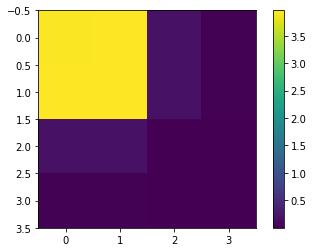

In [11]:
keys = ['center_nfw_x', 'center_nfw_y', 'rsang', 'alphars']

ndim = len(keys)

means = [0,0,.16, .003]

randomness = .01
cov = 0.5 - randomness * np.random.rand(ndim**2).reshape((ndim,ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

for i in range(ndim):
    for j in range(ndim):
        keys_ij = [keys[i], keys[j]]
        
        ratio = 1
        for key in keys_ij:
            if key == 'rsang':
                ratio *= .1
            elif key == 'alphars':
                ratio *= .01
            else:
                ratio *= 2
        cov[i,j] *= ratio

plt.imshow(cov); plt.colorbar(); plt.show()

In [12]:
nwalkers = 40
p0 = means + np.sqrt(np.diag(cov)) * (np.random.rand(nwalkers, ndim)-.5)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[])

In [13]:
%%time
sampler.reset()
state = sampler.run_mcmc(p0, 100)

/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]


CPU times: user 51 s, sys: 9.54 s, total: 1min
Wall time: 1min


What is this runtime warning? I don't know, but maybe should look into it...

In [21]:
%%time
sampler.reset()
state2 = sampler.run_mcmc(state, 100)

CPU times: user 47.8 s, sys: 9.18 s, total: 57 s
Wall time: 57 s


In [ ]:
%%time
sampler.reset()
state3 = sampler.run_mcmc(state2, 1000)

key center_nfw_x


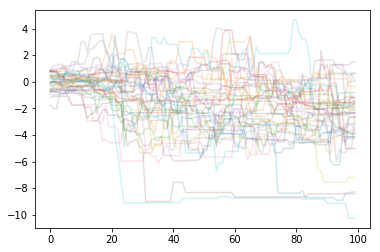

key center_nfw_y


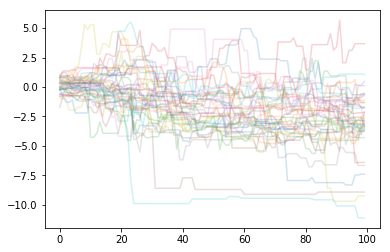

key rsang


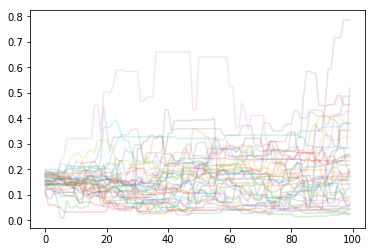

key alphars


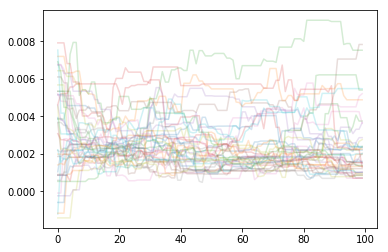

In [14]:
for i, key in enumerate(keys):
    print('key', key)
    for j in range(nwalkers):
        plt.plot(sampler.chain[j,:,i], alpha = .2)
    #plt.ylim(-50,50)
    plt.show()

We can't constrain the parameters very well, but we can reproduce the image very well (as we'll see in a few more cells). By the way, in an older version of this notebook, we demonstrated that if we keep `rsang` and `alphars` fixed, and $z_d \approx z_l$, then we can constrain the location much better (approx +- 5).

In [15]:
xs = sampler.chain[:,:,0].flatten()
#ys = sampler.chain[:,:,1].flatten()

#xs_good = xs[abs(xs) < 100]
#ys_good = ys[abs(xs) < 100] # so that they match up
vars_good = [sampler.chain[:,:,i].flatten()[abs(xs) < 100] for i in range(ndim)]

In [16]:
## Histogram of x and y positions ##

# plt.hist(xs_good.flatten(), bins=50)
# plt.title('center_nfw_x')
# plt.show()
# #
# plt.hist(ys_good.flatten(), bins=50)
# plt.title('center_nfw_y')
# plt.show()

In [17]:
## Calculate covariance matrix for our sample ##

# sample_cov = np.cov(np.vstack(vars_good))
# plt.imshow(sample_cov); plt.colorbar()

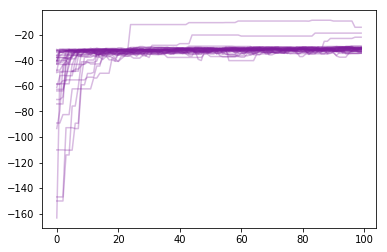

In [18]:
for j in range(nwalkers):
    plt.plot(sampler.lnprobability[j,:], alpha=.3, color='xkcd:purple')
    
#plt.ylim(-500,0)

In [24]:
last_lprobs = sampler.lnprobability[:,-1]
print(last_lprobs) # just to make sure there are no -np.inf 's hiding in here

[-2.97786599 -1.86867549 -2.41646611 -0.72959274 -2.61846402 -3.18509017
 -2.42035345 -2.72850871 -1.43720537 -2.9441602  -1.50285097 -1.29948623
 -0.94246321 -1.80275206 -1.36632057 -2.10781283 -3.96068405 -2.03644726
 -0.69630221 -2.82424626 -3.14500608 -2.38837622 -1.36579669 -4.19938097
 -3.80858177 -1.58199599 -3.46479009 -4.35636641 -1.13825698 -1.96063054
 -1.32271974 -1.96418772 -1.29045802 -2.55678461 -1.31851856 -5.29870314
 -1.78914692 -1.60682752 -1.28279608 -0.9480096 ]


almost truth args [array(0.90557643), array(9.32129031), 0.16387735182302984, 0.003188368994127903]
almost truth error 17.72095676434488


/home/arthur/Documents/cosmo/interlopers/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


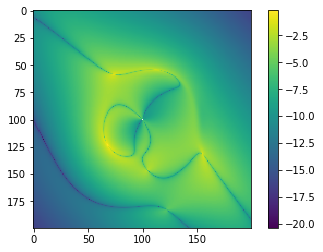

In [29]:
# "truth"-level
nfw_idx = 2 if zl < zd else 1 # todo check this
almost_truth_args = [kwargs_lens[nfw_idx]['center_x'], kwargs_lens[nfw_idx]['center_y'], rsang, alphars]
print('almost truth args', almost_truth_args)
almost_truth_img = args_to_img(almost_truth_args)
print('almost truth error', error(almost_truth_img, image))
plt.imshow(np.log(abs(almost_truth_img - image))); plt.colorbar()

null args [array(-2.39166397), array(-3.38428156), 0.16387735182302984, 0]
null error 50.01195647816636


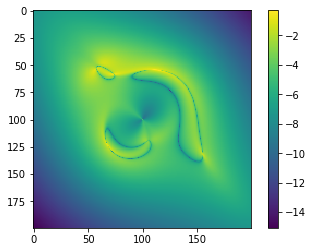

In [20]:
# no subhalos
nfw_idx = 2 if zl < zd else 1 # todo check this
almost_truth_args = [kwargs_lens[nfw_idx]['center_x'], kwargs_lens[nfw_idx]['center_y'], rsang, 0]
print('null args', almost_truth_args)
almost_truth_img = args_to_img(almost_truth_args)
print('null error', error(almost_truth_img, image))
plt.imshow(np.log(abs(almost_truth_img - image))); plt.colorbar()

before, error= 138.91092577246965


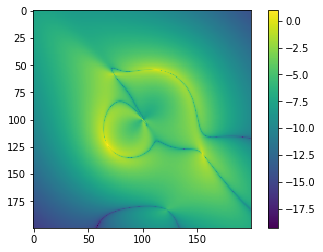

after, error= 2.9778659934284364


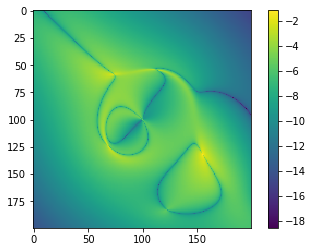

before, error= 45.16619361674603


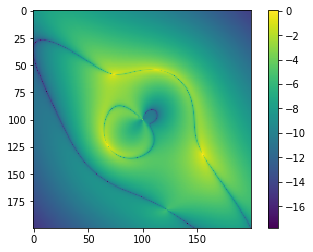

after, error= 1.8686754870538589


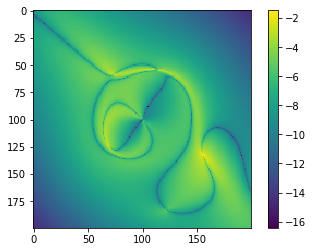

In [28]:
for j in range(nwalkers)[:2]:
#     print('before')
#     plt.imshow(args_to_img(sampler.chain[j,0,:])); plt.colorbar(); plt.show()
#     print('after')
#     plt.imshow(args_to_img(sampler.chain[j,-1,:])); plt.colorbar(); plt.show()
    print('before, error=',error(args_to_img(sampler.chain[j,0,:]),image))
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,0,:])-image))); plt.colorbar(); plt.show()
    print('after, error=',error(args_to_img(sampler.chain[j,-1,:]),image))
    plt.imshow(np.log(abs(args_to_img(sampler.chain[j,-1,:])-image))); plt.colorbar(); plt.show()

## Correlations

Text(0, 0.5, 'center_nfw_y')

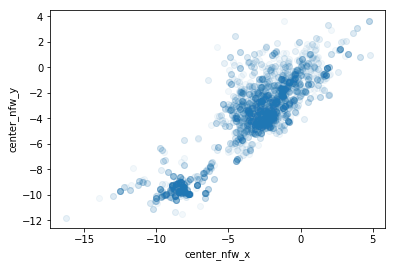

In [24]:
plt.scatter(sampler.chain[:,:,0].flatten(), sampler.chain[:,:,1].flatten(), alpha=.05)
plt.xlabel('center_nfw_x')
plt.ylabel('center_nfw_y')

Text(0, 0.5, 'alphars')

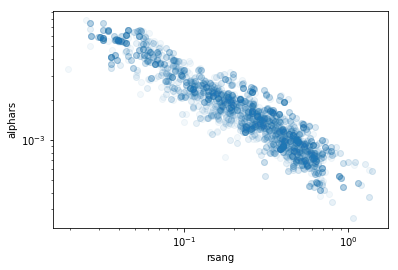

In [29]:
plt.loglog(sampler.chain[:,:,2].flatten(), sampler.chain[:,:,3].flatten(), 'o', alpha=.05)
plt.xlabel('rsang')
plt.ylabel('alphars')

**TODO** : get the graph above in terms of mass!

Text(0, 0.5, 'alphars')

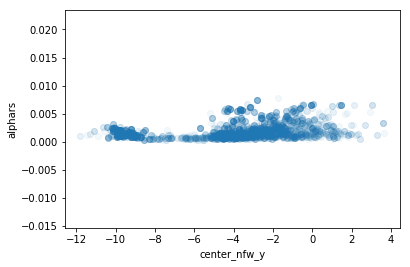

In [28]:
plt.scatter(sampler.chain[:,:,1].flatten(), sampler.chain[:,:,3].flatten(), alpha=.05)
plt.xlabel('center_nfw_y')
plt.ylabel('alphars')

In [ ]:
%matplotlib notebook

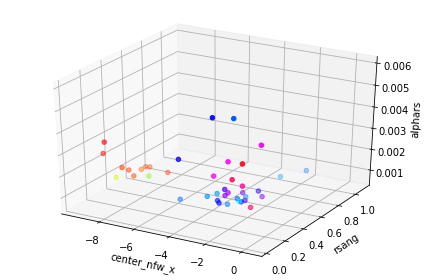

In [30]:
from mpl_toolkits import mplot3d

import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure()
ax = plt.axes(projection="3d")


c_points = sampler.chain[:,-1,1]
x_points = sampler.chain[:,-1,0]
y_points = sampler.chain[:,-1,2]
z_points = sampler.chain[:,-1,3]
ax.scatter3D(x_points, y_points, z_points, c=c_points, cmap='hsv');

ax.set_xlabel('center_nfw_x')
ax.set_ylabel('rsang')
ax.set_zlabel('alphars')

plt.tight_layout()
plt.show()

I played with the 3D graph, moving it around, but it doesn't really tell us anything we couldn't already see from the 2d "cross-section" graphs.